In [1]:
import warnings
import pandas as pd
from itertools import cycle
import gpflow
import numpy as np
from scipy import linalg
from gpflow.utilities import print_summary, positive
from gpflow.ci_utils import ci_niter
from gpflow.optimizers import NaturalGradient
from gpflow import set_trainable
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from collections import namedtuple
import statsmodels.api as sm
import timeit

sns.set(style="white")
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)

np.random.seed(123)

gpflow.config.set_default_float(np.float64)
gpflow.config.set_default_summary_fmt("notebook")

<ipython-input-1-c790307d65ce>:25: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


In [14]:
def country_selection(country_name, loc_mobility=None, loc_covid=None, print_summary=True, plots=True):
    
    avaliable_countries = ["Germany", "Japan", "Australia", "Canada", 
                          "United States", "South Korea", "Italy", "Argentina", 
                          "Turkey", "Thailand", "Colombia", "Mexico",
                          "India", "Kenya", "Bolivia", "Egypt"]
    
    if country_name not in avaliable_countries:
        warnings.warn("The selected country might not have optimal COVID data.")
    else:
        # https://en.wikipedia.org/wiki/List_of_countries_by_inequality-adjusted_HDI
        if country_name in ["Germany", "Japan", "Australia", "Canada"]:
            # Tier 1: 0.800–1.000 (very high)
            tier = 1         
        elif country_name in ["United States", "South Korea", "Italy", "Argentina"]:
            # Tier 2: 0.700–0.799 (high)
            tier = 2
        elif country_name in ["Turkey", "Thailand", "Algeria", "Mexico"]:
            # Tier 3: 0.550–0.699 (medium)
            tier = 3
        else:
            # Tier 4: 0.350–0.549 (low)
            tier = 4
            
    if loc_mobility==None:
        loc_mobility="./Data/Google/Global_Mobility_Report.csv"
        
    mobility_data = pd.read_csv(loc_mobility, 
                                encoding="ISO-8859-1", 
                                parse_dates=["date"],
                                dayfirst=True, low_memory=False)
    
    mobility_data = mobility_data[
        (mobility_data["country_region"]==country_name) & (mobility_data["sub_region_1"].isnull())]
    mobility_data = mobility_data.iloc[:,7:].reset_index(drop=True) # keep only relevant columns
    mobility_data.iloc[:,1:] = mobility_data.iloc[:,1:].apply(lambda x: x/100 + 1)
    
    mobility_data = pd.DataFrame({
        "date": mobility_data["date"],
        "HOME": mobility_data['residential_percent_change_from_baseline'],
        "WORK": mobility_data['workplaces_percent_change_from_baseline'],
        "RECREATIONAL": mobility_data['retail_and_recreation_percent_change_from_baseline'],
        "OTHER": mobility_data.iloc[:,2:5].mean(axis=1)
    })
    mobility_data.reset_index(drop=True, inplace=True)
    
    if loc_covid==None:
        loc_covid="./Data/Microsoft/COVID_CASES.csv"
     # COVID Cases from Microsoft, includes Recovered and Infected
    ms_covid = pd.read_csv(loc_covid, 
                           encoding="ISO-8859-1",
                           parse_dates=["Updated"],
                           dayfirst=False, low_memory=False)
    
    ms_covid = ms_covid[(ms_covid["Country_Region"]==country_name) & (ms_covid["AdminRegion1"].isnull())]
    ms_covid = ms_covid.loc[:,["Updated", "Confirmed", "ConfirmedChange", "Deaths", "Recovered"]]   
    
    # Create the 3 categories S, I, R for US data (UK does not include R)
    ms_covid = ms_covid.fillna(method='ffill').fillna(0)

    # DIFF: Instead of smoothing the I, Daily cases and S, ammend the problematic R value @ 2020-07-18
    # To match the next 2020-07-19
    if country_name=="United States":
        ms_covid.iloc[178, 4] = 1117084.0
        
    # Read the countries population from World Bank Database 2019
    pop_dt = pd.read_excel(
        "./Data/Population/Data_Extract_From_World_Development_Indicators.xls")
    

    population_size = pop_dt.loc[pop_dt.CountryName==country_name, "Total"].values[0]
    
    ms_covid["I"] = ms_covid["Confirmed"] - ms_covid["Deaths"] - ms_covid["Recovered"]
    ms_covid["S"] = population_size - ms_covid["I"]
    ms_covid["index"] = ms_covid["Updated"].dt.dayofyear

    # DIFF: Create a time variable
    # If we have a weekend then assign 0 or weekday 1
    ms_covid["WEEKDAY"] = (ms_covid["Updated"].dt.dayofweek < 5).astype(int)
    
    ms_covid["ConfirmedChange"] = np.log(ms_covid["ConfirmedChange"].rolling(7).median()+1)
    ms_covid["I"] = ms_covid["I"].rolling(7).median()
    ms_covid["S"] = ms_covid["S"].rolling(7).median()

    ms_covid.dropna(inplace=True)
    ms_covid.reset_index(drop=True, inplace=True)
    
    final_data = ms_covid.set_index("Updated").merge(
    mobility_data.set_index("date"), how='left', left_index=True, right_index=True).reset_index()
    final_data.dropna(inplace=True)
    final_data.reset_index(drop=True, inplace=True)
    final_data.columns.values[0] = "Updated"
    
    if plots:
        
        fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(20, 4))
        fig.suptitle("{0} is a Tier {1} country in IHDI".format(country_name, int(tier)), fontsize=16)
        final_data.set_index("Updated")[["ConfirmedChange"]].plot(ax=axs[0, 0])
        final_data.set_index("Updated")[["I"]].plot(ax=axs[0, 1])
        final_data.set_index("Updated")[["S"]].plot(ax=axs[0, 2])
        final_data.set_index("Updated")[["HOME"]].plot(ax=axs[1, 0])
        final_data.set_index("Updated")[["WORK"]].plot(ax=axs[1, 1])
        final_data.set_index("Updated")[["OTHER"]].plot(ax=axs[1, 2])
    
    if print_summary:
        print(round(final_data.describe(), 3))
    
    return(final_data)

In [19]:
def create_multioutput_table():
    
    countries_list = ["Germany", "Japan", "Australia", "Canada", 
                      "United States", "South Korea", "Italy", "Argentina", 
                      "Turkey", "Thailand", "Colombia", "Mexico",
                      "India", "Kenya", "Bolivia", "Egypt"]
    
    for i, c in enumerate(countries_list):
        
        print("\n Read {0} and extract the data...{1}".format(c, i))
        
        if i==0:
            final_data = country_selection(country_name, print_summary=False, plots=False)
            final_data["Country"] = c
            
        data_batch = country_selection(country_name, print_summary=False, plots=False)
        data_batch["Country"] = c
        final_data = pd.concat([final_data, data_batch], axis=0)
        
    return(final_data) 

In [20]:
final_data = create_multioutput_table()


 Read Germany and extract the data...0

 Read Japan and extract the data...1

 Read Australia and extract the data...2

 Read Canada and extract the data...3

 Read United States and extract the data...4

 Read South Korea and extract the data...5

 Read Italy and extract the data...6

 Read Argentina and extract the data...7

 Read Turkey and extract the data...8

 Read Thailand and extract the data...9

 Read Colombia and extract the data...10

 Read Mexico and extract the data...11

 Read India and extract the data...12

 Read Kenya and extract the data...13

 Read Bolivia and extract the data...14

 Read Egypt and extract the data...15


In [21]:
final_data.shape

(2788, 14)

In [22]:
final_data.columns

Index(['Updated', 'Confirmed', 'ConfirmedChange', 'Deaths', 'Recovered', 'I',
       'S', 'index', 'WEEKDAY', 'HOME', 'WORK', 'RECREATIONAL', 'OTHER',
       'Country'],
      dtype='object')

c:\programdata\anaconda3\envs\kassiopia\lib\site-packages\IPython\core\interactiveshell.py:3338: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


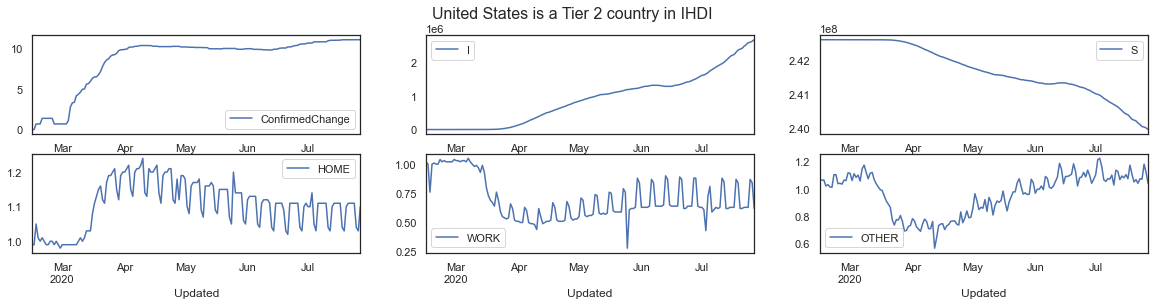

In [4]:
final_data = country_selection(country_name, print_summary=False)

In [5]:
final_data.head()

,Updated,Confirmed,ConfirmedChange,Deaths,Recovered,I,S,index,WEEKDAY,HOME,WORK,RECREATIONAL,OTHER
0,2020-02-15,15,0.000000,1.0,3.0,9.0,242620791.0,46,0,0.99,1.02,1.06,1.066667
1,2020-02-16,15,0.000000,1.0,3.0,10.0,242620790.0,47,0,0.99,1.00,1.07,1.063333
2,2020-02-17,18,0.693147,2.0,3.0,11.0,242620789.0,48,1,1.05,0.76,1.06,1.063333
3,2020-02-18,21,0.693147,2.0,3.0,11.0,242620789.0,49,1,1.01,1.00,1.00,1.020000
4,2020-02-19,24,0.693147,2.0,3.0,11.0,242620789.0,50,1,1.00,1.01,1.02,1.030000
